# Gaussian Mixture Models

$$
\begin{align}
    p({\bf x}) &= \sum_{{\bf z}}p({\bf z})p({\bf x}|{\bf z})\\
               &= \sum_{k}\pi_k \mathcal{N}({\bf x}|{\boldsymbol \mu}_k, {\boldsymbol \Sigma}_k)
\end{align}
$$

In [362]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from numpy.random import randn, seed
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap

points_cmap = ListedColormap(["Yellow", "Red"])

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(precision=3, suppress=True)

## The EM Algorithm
Given a GMM, the goal is to maximize the likelilhood function w.r.t. the parameters

1. Initialize the means $\boldsymbol \mu_k$, covariances $\boldsymbol \Sigma_k$ and mixing coefficients $\pi_k$, and evaluate the initial value of the log likelihood

2. **E Step**: Evaluate the responsibilites using the current parameter values
$$
    \gamma(z_{nk}) = \frac{\pi_k \mathcal{N}({\bf x}_n|\boldsymbol \mu_k, \boldsymbol \Sigma_k)}{\sum_{j=1}^K\pi_j \mathcal{N}({\bf x}_n|\boldsymbol \mu_j, \boldsymbol \Sigma_j)}
$$

3. **M Step**: Re-estimate the parameters using the current probabilities

$$
    \boldsymbol\mu_{k}^{\text{new}} = \frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk}) {\bf x}_n
$$

$$
    \boldsymbol{\Sigma}_k^{\text{new}} = \frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk}) ({\bf x}_n - \boldsymbol\mu_{k}^{\text{new}})({\bf x}_n - \boldsymbol\mu_{k}^{\text{new}})^T
$$

$$
    \pi_k^{\text{new}} = \frac{N_k}{N}
$$

Where $N_K = \sum_{n=1}^N \gamma(z_{nk})$

4. Evaluate the log likelihood and check for convergence of either the parameters or the log likelihood. If convergence is not met return to step 2.

$$
    \log p({\bf X}|\boldsymbol\mu, \boldsymbol\Sigma, \boldsymbol\pi) = \sum_{n=1}^N \log\left(\sum_{k=1}^K\pi_k \mathcal{N}({\bf x}_n|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\right)
$$

Where

* $\mathcal{N}(x|\mu, \sigma^2) = (2\pi)^{-M/2}|\Sigma|^{-1/2}\exp\left(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right)$

---- 

**Note**:  
* The covariance matrices can conviniently be initialized to the sample covariances of the clusters found by the K-means algorithm, and
* the mixing coeffients can be set to the fractions of data points assigned to the respective clusters

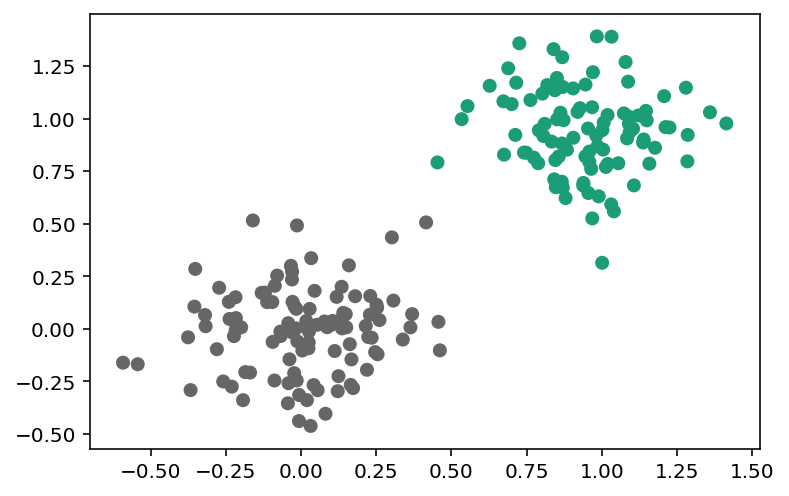

In [261]:
X, y, _ = make_biclusters((200, 2), 2, noise=0.2, random_state=314, minval=0, maxval=1)
plt.scatter(*X.T, c=y.argmax(axis=0), cmap="Dark2")

In [277]:
classes = np.array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1]).astype(bool)

In [263]:
def covariance(X):
    """
    Parameters
    ----------
    X: np.array(N, M)
        Array with N real-valued observations with vectors
        of size M
    """
    X = X.T
    M, N = X.shape
    mu = X.mean(axis=1, keepdims=True)
    cov = X - mu
    cov = cov @ cov.T / (N - 1)
    return cov

def correlation(X):
    cov = covariance(X)
    sigmas = X.T.std(axis=1, ddof=1)
    sigmas = np.outer(sigmas, sigmas)
    return cov / sigmas

In [286]:
k1 = X[classes]
k2 = X[~classes]

In [355]:
# Can start anywhere we want
mu1 = np.array([-0.2, 1])
mu2 = np.array([0.75, 0])

In [356]:
Sigma1 = covariance(k1)
Sigma2 = covariance(k2)

In [357]:
pi1 = len(k1) / len(X)
pi2 = len(k2) / len(X)

In [358]:
N1 = multivariate_normal(mean=mu1, cov=Sigma1)
N2 = multivariate_normal(mean=mu2, cov=Sigma2)

In [359]:
x0, y0 = X.min(axis=0)
x1, y1 = X.max(axis=0)

In [ ]:
 c=y.argmax(axis=0), cmap=points_cmap

(-0.4619519601685454, 1.3917684354801592)

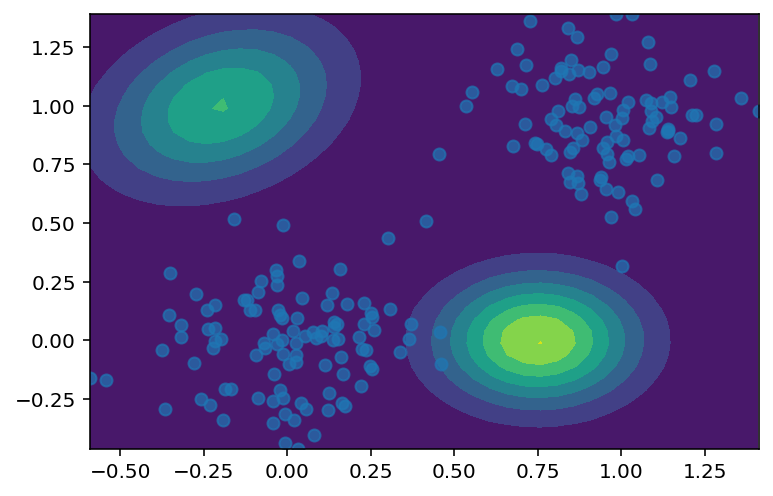

In [367]:
step = 0.05
xx, yy = np.mgrid[x0:x1:step, y0:y1:step]

density1 = np.c_[xx.ravel(), yy.ravel()]
density1 = N1.pdf(density1).reshape(xx.shape)

density2 = np.c_[xx.ravel(), yy.ravel()]
density2 = N2.pdf(density2).reshape(xx.shape)

density = pi1 * density1 + pi2 * density2

plt.contourf(xx, yy, density);
plt.scatter(*X.T, alpha=0.7)
plt.xlim(x0, x1)
plt.ylim(y0, y1)

In [414]:
def responsibilities(k, pi, mu, sigma):
    Ns = [multivariate_normal(mean=mu_i, cov=Sigma_i) for mu_i, Sigma_i in zip(mu, sigma)]
    def respons(x):
        elements = [pi_i * Ni.pdf(x) for pi_i, Ni in zip(pi, Ns)]
        return elements[k] / np.sum(elements, axis=0)
    return respons

### E Step

In [438]:
Sigma =  [Sigma1, Sigma2]
mu = [mu1, mu2]
pi = [pi1, pi2]

r1 = responsibilities(0, pi, mu, Sigma)(X)
r2 = responsibilities(1, pi, mu, Sigma)(X)

(-0.4619519601685454, 1.3917684354801592)

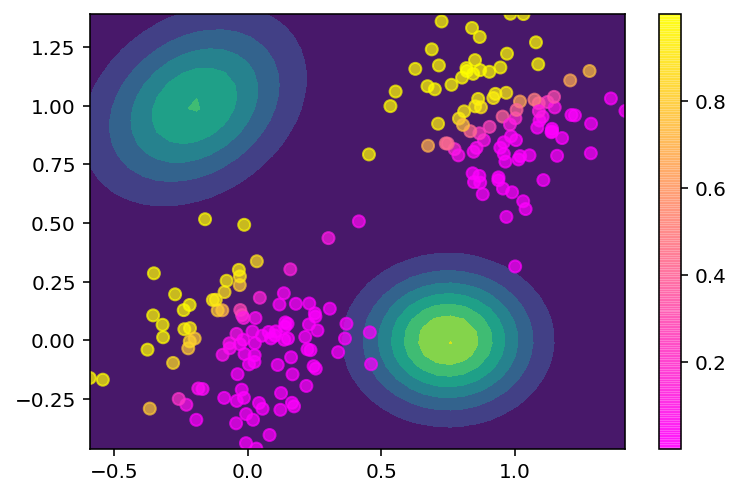

In [432]:
plt.contourf(xx, yy, density);
plt.scatter(*X.T, alpha=0.7, c=r1, cmap="spring")
plt.colorbar()
plt.xlim(x0, x1)
plt.ylim(y0, y1)

### M Step

In [445]:
N1, N2 = r1.sum(), r2.sum()

mu1 = (r1[:, np.newaxis] * X).sum(axis=0) / N1
mu2 = (r2[:, np.newaxis] * X).sum(axis=0) / N2

70.56261107071441